In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
EPOCHS = 100
WEIGHT_DECAY = 5e-4
FAMILY_WEIGHT = 0.05
IDENTITY_WEIGHT = 0.05
LEARNING_RATE = 0.01
MULTI_STEP_LR_DECAY = [30, 60, 90]
DATASET = 'original' # choice = ['original', 'SR9', 'SR20']


In [3]:
import os
import math
import pickle
import cv2
from glob import glob

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import matplotlib.image as img

class TrainDataset(Dataset):
    def __init__(self, transform = None):
      # Save the entire path for data (list and label as well)
        super(TrainDataset, self).__init__()
        self.transform = transform

        # Instead of local drive, I am using files in gdrive mounted
        #self.all_images = glob(DATASET + '/train/train-faces/' + "*/*/*.jpg") # original
        self.all_images = glob('/gdrive/MyDrive/Kinship Recognition Starter/train/train-faces/' + "*/*/*.jpg") # original

        self.img_pathes = []
        
        all_classes = [s.split('/')[-3] for s in self.all_images] # family name list
        self.class_index = list(set(all_classes)) # family index
        
        all_classes2 = [s.split('/')[-3] + '_' + s.split('/')[-2] for s in self.all_images] # identity name list
        self.class_index2 = list(set(all_classes2)) # identity index
        
        self.classes = [self.class_index.index(name) for name in all_classes] # family label for each sample
        self.classes2 = [self.class_index2.index(name) for name in all_classes2] # identity label for each sample
        
    def __len__(self):
      # the size of the entire dataset
        return len(self.all_images)
        
    def __getitem__(self, idx):
      # function that returns data x, label one by one when there is an input idx
        img_path = self.all_images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform is not None: # augmentations
            img = self.transform(img)
                    
        if img.size(0) == 1: # if greyscale, repeat
            img = img.repeat(3, 1, 1)
            
        # 3 C(RGB) // 1 Gray(black) x Height x Weight
        family_label = torch.LongTensor([self.classes[idx]]) # family label
        identity_label = torch.LongTensor([self.classes2[idx]]) #

        return img, family_label, identity_label

In [4]:
# Reference: https://github.com/cydonia999/VGGFace2-pytorch
# ZQ. Cao, L. Shen, W. Xie, O. M. Parkhi, A. Zisserman, VGGFace2: A dataset for recognising faces across pose and age, 2018.
# https://arxiv.org/pdf/1710.08092.pdf

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class SEModule(nn.Module):

    def __init__(self, planes, compress_rate):
        super(SEModule, self).__init__()
        self.conv1 = nn.Conv2d(planes, planes // compress_rate, kernel_size=1, stride=1, bias=True)
        self.conv2 = nn.Conv2d(planes // compress_rate, planes, kernel_size=1, stride=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = F.avg_pool2d(module_input, kernel_size=module_input.size(2))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        return module_input * x


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        # SENet
        compress_rate = 16
        # self.se_block = SEModule(planes * 4, compress_rate)  # this is not used.
        self.conv4 = nn.Conv2d(planes * 4, planes * 4 // compress_rate, kernel_size=1, stride=1, bias=True)
        self.conv5 = nn.Conv2d(planes * 4 // compress_rate, planes * 4, kernel_size=1, stride=1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)


        ## senet
        out2 = F.avg_pool2d(out, kernel_size=out.size(2))
        out2 = self.conv4(out2)
        out2 = self.relu(out2)
        out2 = self.conv5(out2)
        out2 = self.sigmoid(out2)
        # out2 = self.se_block.forward(out)  # not used

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out2 * out + residual
        # out = out2 + residual  # not used
        out = self.relu(out)
        return out


class SENet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, include_top=True):
        self.inplanes = 64
        super(SENet, self).__init__()
        self.include_top = include_top
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        if not self.include_top:
            return x
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def senet50(**kwargs):
    """Constructs a SENet-50 model.
    """
    model = SENet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def load_state_dict(model, fname):
    """
    Set parameters converted from Caffe models authors of VGGFace2 provide.
    See https://www.robots.ox.ac.uk/~vgg/data/vgg_face2/.
    Arguments:
        model: model
        fname: file name of parameters converted from a Caffe model, assuming the file format is Pickle.
    """
    with open(fname, 'rb') as f:
        weights = pickle.load(f, encoding='latin1')

    own_state = model.state_dict()
    for name, param in weights.items():
        if name in own_state:
            try:
                own_state[name].copy_(torch.from_numpy(param))
            except Exception:
                raise RuntimeError('While copying the parameter named {}, whose dimensions in the model are {} and whose '\
                                   'dimensions in the checkpoint are {}.'.format(name, own_state[name].size(), param.size()))
        else:
            raise KeyError('unexpected key "{}" in state_dict'.format(name))

In [5]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        N_IDENTITY = 8631
        include_top = True
        self.backbone = senet50(num_classes=N_IDENTITY, include_top=include_top)
        load_state_dict(self.backbone, '/gdrive/MyDrive/Kinship Recognition Starter/senet50_ft_weight.pkl')
        self.backbone.fc = nn.Linear(2048, 1024) # reset top layer
        self.embedding = nn.Linear(1024, 512)
        self.family_classifier = nn.Linear(1024, 192) 
        self.identity_classifier = nn.Linear(1024, 966)
        
    def forward(self, x):
        feature = self.backbone(x)
        feature = F.relu(feature)
        
        embedding = self.embedding(feature)
        embedding = F.normalize(embedding, p=2)
        
        family_pred = self.family_classifier(feature)
        identity_pred = self.identity_classifier(feature)
        
        return embedding, family_pred, identity_pred

In [6]:
def pos_neg_mask(family_label):
    family_label = family_label.squeeze()
    pos_mask = family_label.unsqueeze(0) == family_label.unsqueeze(1) # size: Batch x Batch
    pos_mask = pos_mask.float() # each index of row is anchor, and the other sample has the same family label
    # positive element value is 1

    neg_mask = 1 - pos_mask # 
    pos_mask -= torch.eye(family_label.size(0), device=family_label.device).float() # I matrix
    return pos_mask, neg_mask

# using anchor positive, negative indexes
def triplet_sampling(pos_mask, neg_mask):
    pos_pair_idx = pos_mask.nonzero()
    apns = []
    for pair_idx in pos_pair_idx:
        anchor_idx = pair_idx[0]
        neg_indices = neg_mask[anchor_idx].nonzero()

        apn = torch.cat(
            (pair_idx.unsqueeze(0).repeat(len(neg_indices), 1), neg_indices),
            dim=1,
        )
        apns.append(apn)
    apns = torch.cat(apns, dim=0)
    anchor_idx = apns[:, 0]
    pos_idx = apns[:, 1]
    neg_idx = apns[:, 2]

    return anchor_idx, pos_idx, neg_idx

# define triplet loss
class Triplet(torch.nn.Module):
    def __init__(self, p=2, margin=0.2):
        super().__init__()
        self.p = p
        self.margin = margin

    # with mask, find triplet loss
    def forward(self, embeddings, targets):
        pos_mask, neg_mask = pos_neg_mask(targets)
        anchor_idx, pos_idx, neg_idx = triplet_sampling(pos_mask, neg_mask)
        if pos_idx is None:
            return 0

        anchor_embed = embeddings[anchor_idx]
        positive_embed = embeddings[pos_idx]
        negative_embed = embeddings[neg_idx]

        loss = torch.nn.functional.triplet_margin_loss(
            anchor_embed,
            positive_embed,
            negative_embed,
            margin=self.margin, # margin = triplet margin
            p=self.p, # p = p-norm
            reduction="mean",
        )                
        return loss

In [7]:
model = BaseModel()
model.cuda()
#model.load_state_dict(torch.load(model_path)) # for fine-tune

train_dataset = TrainDataset(transform=transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize((131.0912/255., 103.8827/255., 91.4953/255.), (1, 1, 1))
    ]))

train_loader = DataLoader(train_dataset, num_workers=4, batch_size=64, shuffle=True)

criterion = Triplet()
classifier_criterion = torch.nn.CrossEntropyLoss()

model.train()

num_epoch = EPOCHS
family_weight = FAMILY_WEIGHT
identity_weight = IDENTITY_WEIGHT
weight_decay = WEIGHT_DECAY

params = list(model.backbone.fc.parameters()) + list(model.embedding.parameters()) + list(model.family_classifier.parameters()) + list(model.identity_classifier.parameters()) # for training only new layers
#params = list(model.parameters()) # for fine tuning
optimizer = optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, MULTI_STEP_LR_DECAY, gamma=0.1)

train_losses = []

for epoch in range(num_epoch):
    total_loss = 0.
    total_tri_loss = 0.
    total_family_loss = 0.
    total_identity_loss = 0.
    for batch_idx, (data, family_label, identity_label) in enumerate(train_loader):
        data, family_label, identity_label = data.cuda(), family_label.cuda(), identity_label.cuda()
        family_label, identity_label = family_label.squeeze(), identity_label.squeeze()

        optimizer.zero_grad() 
        embedding, family_pred, identity_pred = model(data) # size : Batch x 512
        tri_loss = criterion(embedding, family_label)
        family_loss = classifier_criterion(family_pred, family_label) 
        identity_loss = classifier_criterion(identity_pred, identity_label)

        loss = tri_loss + family_loss * family_weight + identity_loss * identity_weight
        loss.backward()

        total_tri_loss += tri_loss.item() * data.size(0)
        total_family_loss += family_loss.item() * data.size(0)
        total_identity_loss += identity_loss.item() * data.size(0)

        total_loss += loss.item() * data.size(0)

        optimizer.step()

    scheduler.step()

    total_loss /= 5045 # 5045 -> the # of data points
    total_tri_loss /= 5045
    total_family_loss /= 5045
    total_identity_loss /= 5045
    train_losses.append(total_loss)
    print ("Epoch {}, total_loss: {}, total_tri_loss: {}, total_family_loss: {}, total_identity_loss: {}".format(epoch, total_loss, total_tri_loss, total_family_loss, total_identity_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0, total_loss: 0.6925695864131122, total_tri_loss: 0.10306789269237027, total_family_loss: 4.983549163126496, total_identity_loss: 6.806484489894599
Epoch 1, total_loss: 0.5629363658052488, total_tri_loss: 0.07210656616567265, total_family_loss: 3.891225303341778, total_identity_loss: 5.925370483379534
Epoch 2, total_loss: 0.4503195798905092, total_tri_loss: 0.0595680910416457, total_family_loss: 2.8929821432168468, total_identity_loss: 4.922047475355468
Epoch 3, total_loss: 0.3604497375407942, total_tri_loss: 0.05824776625978817, total_family_loss: 2.126397561979719, total_identity_loss: 3.917641776475254
Epoch 4, total_loss: 0.2911179948432004, total_tri_loss: 0.055766846258765525, total_family_loss: 1.6234388290713397, total_identity_loss: 3.083584017843392
Epoch 5, total_loss: 0.2333377222298867, total_tri_loss: 0.04839645231768445, total_family_loss: 1.2771272685293873, total_identity_loss: 2.4216981072137567
Epoch 6, total_loss: 0.1999078539719785, total_tri_loss: 0.0513240

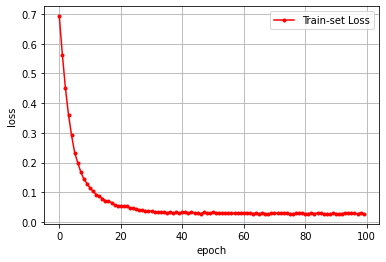

In [8]:
torch.save(model.state_dict(), 'model.pth.tar') # download this tar file from colab to my local drive (to use it for new_test.ipynb)

x = list(range(num_epoch))
plt.plot(x, train_losses, marker='.', c='red', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()